In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 19 17:08:19 2024

@author: Rodrigo Meira
"""
from libs.eos_database import *
from libs.compressor_class import *
from libs.compression import *
from libs.gc_eos_soave import *
from libs.viscosity import *
from libs.plenum_system import *
from libs.simulation import *
from libs.model import *

from casadi import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import torch
from scipy.stats import qmc
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import time

In [2]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

vlv = valve(kv=0.38)
Vpp = 2.0 
Lc = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 4500000, None, 1, 0, Aij, volumn_desviation, 'gas')
comp = CompressorClass()
visc = viscosity(mixture, volumn_desviation)
compressor = compression(gas, comp, visc)
plenum_sys = plenum(gas, compressor, vlv, Vpp, Lc, A1)

In [3]:
nAlphas = 300

sampler_N_RotS = qmc.LatinHypercube(d=1)  # d=1 porque estamos amostrando uma única variável
samples_N_RotS = sampler_N_RotS.random(n=nAlphas+1)
N_RotS = qmc.scale(samples_N_RotS, 600, 750).flatten()  # Redimensiona para 1D
sampler_alphas = qmc.LatinHypercube(d=1)
samples_alphas = sampler_alphas.random(n=nAlphas+1)
alphas = qmc.scale(samples_alphas, 0.36, 0.65).flatten()

nData = 160
dt = 0.5
timestep = 3
x0 = [14.9919, 339.69, 0.42885]
z0 = [6245.39, 6245.39, 321.672, 0.445562, 319.423, 0.503621, 320.097, 0.396345, 339.69, 0.42885, 0.514917]
u0 = [4500, 300, 600, alphas[0], 5000]

In [ ]:
# sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas, alphas, N_RotS, nData, dt, timestep)
# x_values, z_values, time_steps, alpha_values, N_values, x_train, y_train, x_min, x_max, y_min,y_max = sim.run()

# sim_data = {
#     "x_values": x_values,
#     "z_values": z_values,
#     "time_steps": time_steps,
#     "x_train": x_train,
#     "y_train": y_train,
#     "x_min": x_min,
#     "x_max": x_max,
#     "y_min": y_min,
#     "y_max": y_max

# }

# np.savez(
#     "simulation_data.npz",
#     x_values=x_values,
#     z_values=z_values,
#     time_steps=time_steps,
#     alpha_values=alpha_values,
#     N_values=N_values,
#     x_train=x_train,
#     y_train=y_train,
#     x_min=x_min,
#     x_max=x_max,
#     y_min = y_min,
#     y_max = y_max

# )


In [ ]:
# data = np.load("simulation_data.npz")

# x_values = data["x_values"]
# z_values = data["z_values"]
# time_steps = data["time_steps"]
# alpha_values = data["alpha_values"]
# N_values = data["N_values"]
# x_train = data["x_train"]
# y_train = data["y_train"]
# x_min = data["x_min"]
# x_max = data["x_max"]
# y_min = data["y_min"]
# y_max = data["y_max"]


# x_min = torch.tensor(x_min, dtype = torch.float32)
# x_max = torch.tensor(x_max, dtype = torch.float32)
# y_min = torch.tensor(y_min, dtype = torch.float32)
# y_max = torch.tensor(y_max, dtype = torch.float32)
# x_train = torch.tensor(np.array(x_train), dtype=torch.float32)
# y_train = torch.tensor(np.array(y_train), dtype=torch.float32)
# x_train_split, X_val, y_train_split, y_val = train_test_split(
#     x_train, 
#     y_train, 
#     test_size=0.3,  
#     random_state=42,  
#     shuffle=True      
# )
# y_train_split = y_train_split.squeeze()
# y_val = y_val.squeeze()
# train_dataset = torch.utils.data.TensorDataset(x_train_split, y_train_split)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 64, shuffle=True)
# val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= 64, shuffle=False)

In [ ]:
model = MyModel(150, dt, x_max, x_min, y_min, y_max, plenum_sys)# Criar a instância do modelo novamente

In [ ]:
# modelo = MyModel(200, dt, x_max, x_min, y_min, y_max, plenum_sys)  # mesma definição usada antes
# modelo.load_state_dict(torch.load('pesos_modelo.pth'))


In [ ]:
train_loss_values = model.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr= 1e-4,
    epochs=30,
    optimizers=torch.optim.Adam,
    patience=2,
    factor=0.5,
    gas = gas
)

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [4]:
nAlphas_teste = 7

sampler_N_RotS_teste = qmc.LatinHypercube(d=1)  # d=1 porque estamos amostrando uma única variável
samples_N_RotS_teste = sampler_N_RotS_teste.random(n=nAlphas_teste+1)
N_RotS_teste = qmc.scale(samples_N_RotS_teste, 600, 750).flatten()  # Redimensiona para 1D
sampler_alphas_teste = qmc.LatinHypercube(d=1)
samples_alphas_teste = sampler_alphas_teste.random(n=nAlphas_teste+1)
alphas_teste = qmc.scale(samples_alphas_teste, 0.35, 0.65).flatten()  

sim2 = sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas_teste, alphas_teste, N_RotS_teste, 160, dt, timestep)
x_values_teste, z_values_teste, time_steps, alpha_values_teste, N_values_teste, x_teste, y_teste, x_min, x_max, y_min, y_max, tempo = sim.run()
interval3 = np.linspace(0, 160*nAlphas_teste, len(x_teste))

CasADi - 2025-10-02 13:12:48 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


In [ ]:
# torch.onnx.export(
#     model,
#     x_teste,
#     "modelo_simples15.onnx",
#     export_params=True,
#     opset_version=17,
#     input_names=["input"],
#     output_names=["output"],
#     dynamic_axes={
#         "input": {0: "batch_size"},  # Permite batch variável
#         "output": {0: "batch_size"},
#     },
# )

In [5]:
import onnxruntime as ort
import numpy as np

# Converter o tensor para NumPy e ajustar o dtype
x_teste_np = x_teste.detach().cpu().numpy().astype(np.float32)  # Garanta float32

# Se o modelo esperar um batch dimension (ex: [batch, seq_len, features]), adicione:
if x_teste_np.ndim == 1:
    x_teste_np = x_teste_np[np.newaxis, ...]  # Adiciona dimensão de batch (batch=1)

# Carregar o modelo ONNX
ort_session = ort.InferenceSession("modelo_PINN_v1.onnx")

# Executar inferência corretamente
input_name = ort_session.get_inputs()[0].name
outputs = ort_session.run(None, {input_name: x_teste_np})[0]

In [ ]:
print(x_teste.shape)

In [6]:
onnx_model_path = "./modelo_PINN_v1.onnx"
onnx_session = ort.InferenceSession(onnx_model_path)


# Iniciar listas com os 3 primeiros passos
massFlowrate_pred = [x_teste[0, 0, 0].item(), x_teste[0, 1, 0].item(), x_teste[0, 2, 0].item()]
Temperatura_pred = [x_teste[0, 0, 1].item(), x_teste[0, 1, 1].item(), x_teste[0, 2, 1].item()]
PlenumPressure_pred = [x_teste[0, 0, 2].item(), x_teste[0, 1, 2].item(), x_teste[0, 2, 2].item()]
Pressure2_pred = [x_teste[0, 0, 3].item(), x_teste[0, 1, 3].item(), x_teste[0, 2, 3].item()]
Temperatura2_pred = [x_teste[0, 0, 4].item(), x_teste[0, 1, 4].item(), x_teste[0, 2, 4].item()]

input_tensor = torch.zeros((1, 3, 7), dtype=torch.float32)

# Lista para armazenar TODAS as predições (com 14 variáveis por passo)
all_predictions = []

tm1 = time.time()

for i in range(len(interval3)):
    # Atualiza as entradas com as 3 últimas predições
    input_tensor[0, :, 0] = torch.tensor(massFlowrate_pred[-3:])
    input_tensor[0, :, 1] = torch.tensor(Temperatura_pred[-3:])
    input_tensor[0, :, 2] = torch.tensor(PlenumPressure_pred[-3:])
    input_tensor[0, :, 3] = torch.tensor(Pressure2_pred[-3:])
    input_tensor[0, :, 4] = torch.tensor(Temperatura2_pred[-3:])
    input_tensor[0, :, 5] = x_teste[i, :, 5]
    input_tensor[0, :, 6] = x_teste[i, :, 6]

    # Previsão com ONNX
    onnx_inputs = {'input': input_tensor.numpy()}
    onnx_outputs = onnx_session.run(None, onnx_inputs)
    output_step = onnx_outputs[0][0]  # vetor de 14 saídas

    # Armazena toda a predição
    all_predictions.append(output_step)

    massFlowrate_pred.append(output_step[0])
    Temperatura_pred.append(output_step[1])
    PlenumPressure_pred.append(output_step[3])
    Pressure2_pred.append(output_step[4])
    Temperatura2_pred.append(output_step[11])

tm2 = time.time()
timeteste = tm2 - tm1

print(f"Tempo de teste: {timeteste:.4f}s")

# Converter para array numpy
all_predictions = np.array(all_predictions)  # shape (N, 14)
y_true = y_teste

# Avaliar R² e RMSE
r2_list = []
rmse_list = []
rmse_list2 = []
print(y_teste.shape)
print(all_predictions.shape)
for i in range(13):
    r2 = r2_score(y_true[:, i], all_predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_true[:, i], all_predictions[:, i]))/np.array(y_max[:, i] - y_min[:, i]).item()
    rmse2 = np.sqrt(mean_squared_error(y_true[:, i], all_predictions[:, i]))
    r2_list.append(r2)
    rmse_list.append(rmse)
    rmse_list2.append(rmse2)
# Exibir resultados
print("\nMétricas por variável:")
for i in range(13):  # Para todas as variáveis de 0 a 13
    print(f"Variável {i} | R² = {r2_list[i]:.4f} | RMSE = {rmse_list[i]:.6f}, RMSE2 = {rmse_list2[i]:.6f})")


Tempo de teste: 0.1105s
torch.Size([1117, 14])
(1117, 14)

Métricas por variável:
Variável 0 | R² = 0.9902 | RMSE = 0.022585, RMSE2 = 0.106023)
Variável 1 | R² = 0.9945 | RMSE = 0.017431, RMSE2 = 0.521955)
Variável 2 | R² = 0.9992 | RMSE = 0.009026, RMSE2 = 0.000800)
Variável 3 | R² = 0.9987 | RMSE = 0.012155, RMSE2 = 31.630377)
Variável 4 | R² = 0.9875 | RMSE = 0.029171, RMSE2 = 97.840561)
Variável 5 | R² = 0.9859 | RMSE = 0.034865, RMSE2 = 0.290477)
Variável 6 | R² = 0.9867 | RMSE = 0.032103, RMSE2 = 0.001266)
Variável 7 | R² = 0.9862 | RMSE = 0.033411, RMSE2 = 0.290961)
Variável 8 | R² = 0.9905 | RMSE = 0.026875, RMSE2 = 0.001293)
Variável 9 | R² = 0.9878 | RMSE = 0.029805, RMSE2 = 0.723486)
Variável 10 | R² = 0.9882 | RMSE = 0.029917, RMSE2 = 0.003055)
Variável 11 | R² = 0.9860 | RMSE = 0.032824, RMSE2 = 0.756508)
Variável 12 | R² = 0.9892 | RMSE = 0.028712, RMSE2 = 0.003067)


/tmp/ipykernel_28827/1017130667.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rmse = np.sqrt(mean_squared_error(y_true[:, i], all_predictions[:, i]))/np.array(y_max[:, i] - y_min[:, i]).item()
/tmp/ipykernel_28827/1017130667.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rmse = np.sqrt(mean_squared_error(y_true[:, i], all_predictions[:, i]))/np.array(y_max[:, i] - y_min[:, i]).item()
/tmp/ipykernel_28827/1017130667.py:60: DeprecationWarning: __array__ implement

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Converter listas para numpy arrays (removendo os 3 primeiros)
massFlowrate_pred = np.array(massFlowrate_pred[3:])
Temperatura_pred = np.array(Temperatura_pred[3:])
PlenumPressure_pred = np.array(PlenumPressure_pred[3:])
Pressure2_pred = np.array(Pressure2_pred[3:])
Temperatura2_pred = np.array(Temperatura2_pred[3:])
all_predictions = np.array(all_predictions)[3:]
y_teste = np.array(y_teste)[3:]

# Labels e índices desejados
labels = [
    r'$\dot{m}$ / kg/s', r'$T_p$ / K', r'$V_p$ / $m^{3}$/kmol', r'$P_p$ / kPa', r'$P_2$ / kPa', r'$T_{imp} / K$',
    r'$V_{imp}$ / $m^{3}$/kmol', r'$T_{dif} / K$', r'$V_{dif}$ / $m^{3}$/kmol', r'$T_{2s}$ / K', r'$V_{2s}$ / $m^{3}$/kmol', r'$T_2$ / K',
    r'$V_2$ / $m^{3}$/kmol'
]

indices_desejados = [1, 2, 3, 4, 5, 6, 7, 8, 11, 12] 
# Mostrar um gráfico por vez

/tmp/ipykernel_28827/3765809715.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_teste = np.array(y_teste)[3:]


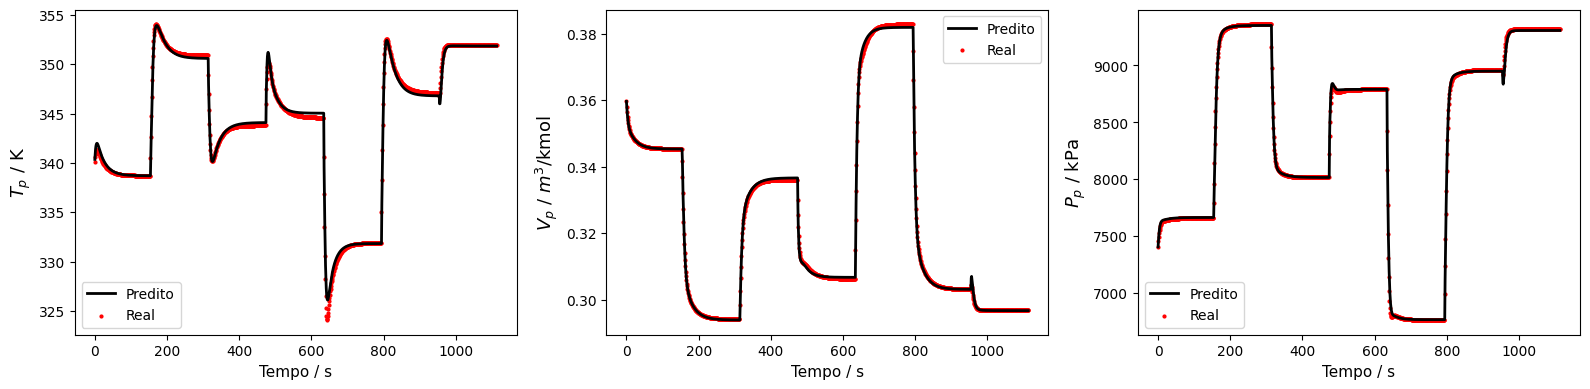

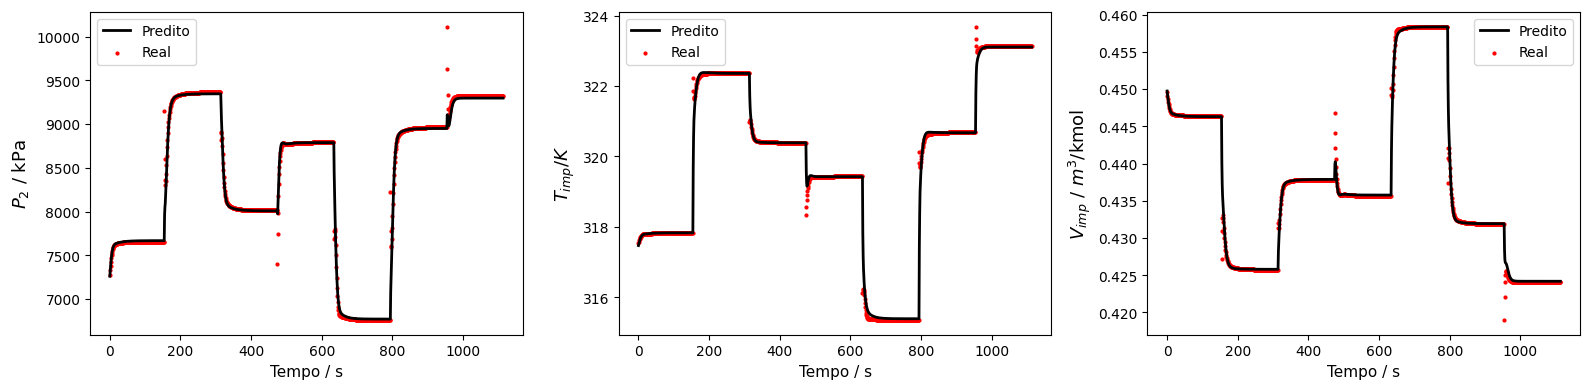

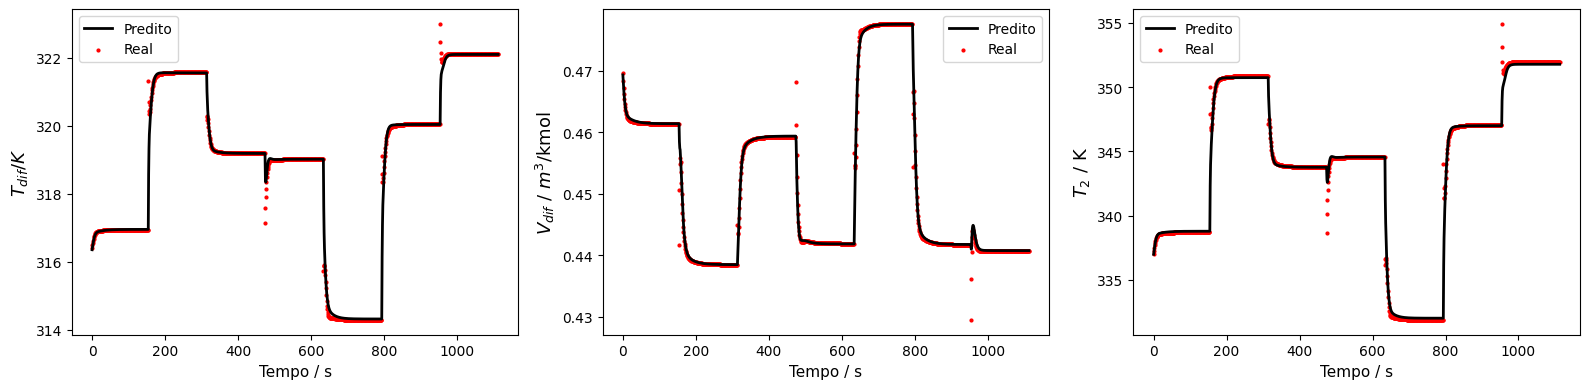

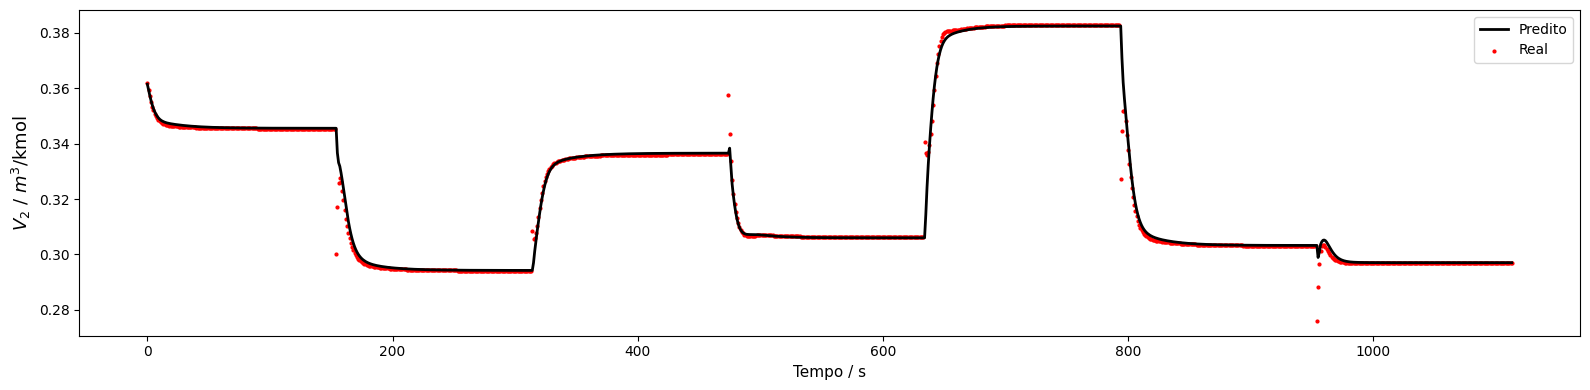

In [8]:
plots_per_fig = 3
num_plots = len(indices_desejados)
num_figs = (num_plots + plots_per_fig - 1) // plots_per_fig  # teto da divisão

for fig_idx in range(num_figs):
    start = fig_idx * plots_per_fig
    end = min(start + plots_per_fig, num_plots)
    
    fig, axs = plt.subplots(1, end - start, figsize=(16, 4))

    # Garante que axs é iterável
    if end - start == 1:
        axs = [axs]

    for j, ax in enumerate(axs):
        idx = indices_desejados[start + j]
        
        ax.plot(all_predictions[:, idx], label='Predito', color='black', linewidth=2)
        ax.scatter(np.arange(len(y_teste[:, idx])), y_teste[:, idx], label='Real', color='red', s=4)
        
        ax.set_ylabel(labels[idx], fontsize=13)
        ax.set_xlabel('Tempo / s', fontsize=11)
        ax.legend(fontsize=10)
        ax.tick_params(axis='both', labelsize=10)
        ax.grid(False)

    plt.tight_layout()
    plt.show()

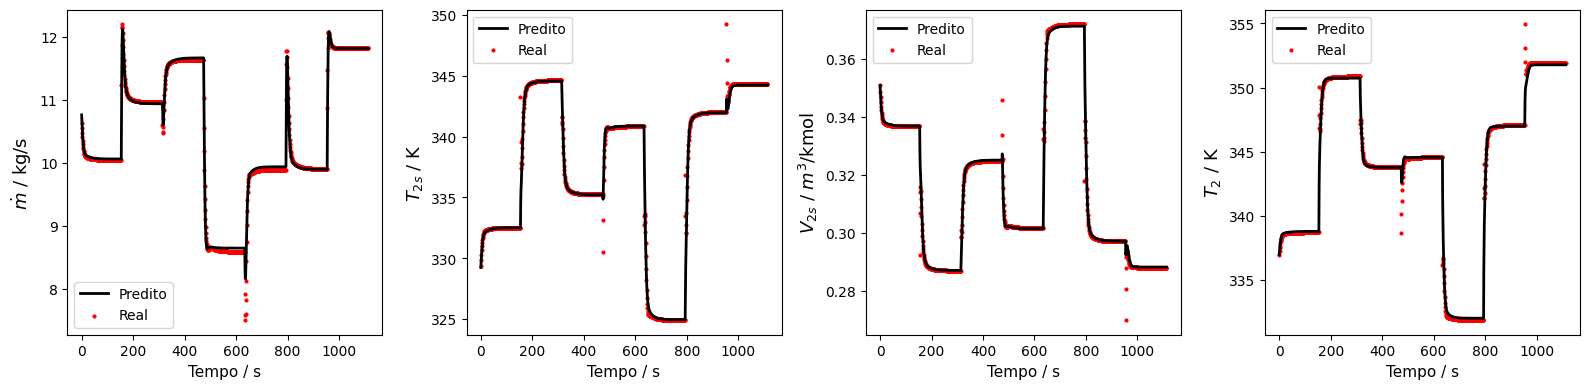

In [9]:
indices_restantes = [0, 9, 10, 11]

plots_per_fig = 4
num_plots = len(indices_restantes)
num_figs = (num_plots + plots_per_fig - 1) // plots_per_fig  # teto da divisão

for fig_idx in range(num_figs):
    start = fig_idx * plots_per_fig
    end = min(start + plots_per_fig, num_plots)
    
    fig, axs = plt.subplots(1, end - start, figsize=(16, 4))

    # Garante que axs é iterável
    if end - start == 1:
        axs = [axs]

    for j, ax in enumerate(axs):
        idx = indices_restantes[start + j]
        
        ax.plot(all_predictions[:, idx], label='Predito', color='black', linewidth=2)
        ax.scatter(np.arange(len(y_teste[:, idx])), y_teste[:, idx], label='Real', color='red', s=4)
        
        ax.set_ylabel(labels[idx], fontsize=13)
        ax.set_xlabel('Tempo / s', fontsize=11)
        ax.legend(fontsize=10)
        ax.tick_params(axis='both', labelsize=10)
        ax.grid(False)

    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# 🔧 Configurações
mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6

# 🕗 Vetor de tempo
tempo = np.arange(len(y_teste)) * 0.5

# 🎨 Cores
cor_pred = 'black'
cor_real = 'red'

# 🔢 Índices
indices = [0, 1, 3]  # Três variáveis

# 🏗️ Tamanho pequeno para Word
fig, axs = plt.subplots(1, 3, figsize=(6.5, 2.2), constrained_layout=True)

for idx, ax in zip(indices, axs):
    ax.plot(tempo, all_predictions[:, idx], label='Predito', color=cor_pred, linewidth=1.8)
    ax.scatter(tempo, y_teste[:, idx], label='Real', color=cor_real, s=2)

    ax.set_ylabel(labels[idx], fontsize=10)
    ax.set_xlabel('Tempo / s ', fontsize=9)
    ax.tick_params(axis='both', labelsize=8)

    for spine in ax.spines.values():
        spine.set_linewidth(1)

    ax.grid(False)

# 🔥 Legenda fora do primeiro gráfico
axs[0].legend(
    fontsize=7,
)

# 📝 Salvamento
plt.savefig("grafico_saida_pequeno_legenda_fora.pdf", bbox_inches='tight')
plt.savefig("grafico_saida_pequeno_legenda_fora.png", dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(5.9, 2.2), constrained_layout=True)

# Primeiro subplot vazio
axs[0].axis('off')

indices = [4, 11]
plot_axes = axs[1:]

for idx, ax in zip(indices, plot_axes):
    ax.plot(tempo, all_predictions[:, idx], label='Predito', color=cor_pred, linewidth=1.8)
    ax.scatter(tempo, y_teste[:, idx], label='Real', color=cor_real, s=2)

    ax.set_ylabel(labels[idx], fontsize=10)
    ax.set_xlabel('Tempo / s', fontsize=9)
    ax.tick_params(axis='both', labelsize=8)

    for spine in ax.spines.values():
        spine.set_linewidth(1)

    ax.grid(False)

plot_axes[0].legend(fontsize=8, loc='upper left')

plt.savefig("grafico_saida_2_pequeno.pdf", bbox_inches='tight')
plt.savefig("grafico_saida_2_pequeno.png", dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
n_runs = 500
tempos_sim = []
tempos_onnx = []

for _ in range(n_runs):
    # Simulação tradicional
    sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas_teste, alphas_teste, N_RotS_teste, 160, dt, timestep)
    _, _, _, _, _, x_teste, y_teste, _, _, _, _, tempo_sim = sim.run()
    tempos_sim.append(tempo_sim)

    # Inferência ONNX
    massFlowrate_pred = [x_teste[0, 0, 0].item(), x_teste[0, 1, 0].item(), x_teste[0, 2, 0].item()]
    Temperatura_pred = [x_teste[0, 0, 1].item(), x_teste[0, 1, 1].item(), x_teste[0, 2, 1].item()]
    PlenumPressure_pred = [x_teste[0, 0, 2].item(), x_teste[0, 1, 2].item(), x_teste[0, 2, 2].item()]
    Pressure2_pred = [x_teste[0, 0, 3].item(), x_teste[0, 1, 3].item(), x_teste[0, 2, 3].item()]
    Temperatura2_pred = [x_teste[0, 0, 4].item(), x_teste[0, 1, 4].item(), x_teste[0, 2, 4].item()]

    input_tensor = torch.zeros((1, 3, 7), dtype=torch.float32)
    all_predictions = []

    tm1 = time.time()
    for i in range(len(x_teste)):
        input_tensor[0, :, 0] = torch.tensor(massFlowrate_pred[-3:])
        input_tensor[0, :, 1] = torch.tensor(Temperatura_pred[-3:])
        input_tensor[0, :, 2] = torch.tensor(PlenumPressure_pred[-3:])
        input_tensor[0, :, 3] = torch.tensor(Pressure2_pred[-3:])
        input_tensor[0, :, 4] = torch.tensor(Temperatura2_pred[-3:])
        input_tensor[0, :, 5] = x_teste[i, :, 5]
        input_tensor[0, :, 6] = x_teste[i, :, 6]

        onnx_inputs = {'input': input_tensor.numpy()}
        onnx_outputs = onnx_session.run(None, onnx_inputs)
        output_step = onnx_outputs[0][0]

        all_predictions.append(output_step)

        massFlowrate_pred.append(output_step[0])
        Temperatura_pred.append(output_step[1])
        PlenumPressure_pred.append(output_step[3])
        Pressure2_pred.append(output_step[4])
        Temperatura2_pred.append(output_step[11])
    tm2 = time.time()
    tempos_onnx.append(tm2 - tm1)

# Cálculo das médias e comparação
media_sim = np.mean(tempos_sim)
media_onnx = np.mean(tempos_onnx)
speedup_medio = media_sim / media_onnx

print(f"\nMédia tempo simulação física (CasADi): {media_sim:.4f} s")
print(f"Média tempo modelo ONNX: {media_onnx:.4f} s")
print(f"Speedup médio: {speedup_medio:.2f}x")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Estilo visual com seaborn
sns.set_style("whitegrid")

plt.rcParams.update({
    'font.size': 22,
    'axes.titlesize': 30,
    'axes.labelsize': 28,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'legend.fontsize': 22,
})

# Filtrando valores negativos
tempos_sim = np.array(tempos_sim)
tempos_onnx = np.array(tempos_onnx)
tempos_sim = tempos_sim[tempos_sim >= 0]
tempos_onnx = tempos_onnx[tempos_onnx >= 0]

plt.figure(figsize=(18, 10))

# Histogramas com barras largas e bordas pretas
plt.hist(tempos_sim, bins=20, alpha=0.8, label='Simulação Física (CasADi)',
         color=sns.color_palette("pastel")[0], edgecolor='black', linewidth=1.5, rwidth=0.95)
plt.hist(tempos_onnx, bins=20, alpha=0.8, label='Modelo ONNX',
         color=sns.color_palette("pastel")[1], edgecolor='black', linewidth=1.5, rwidth=0.95)

# Linhas verticais para as médias
media_sim = np.mean(tempos_sim)
media_onnx = np.mean(tempos_onnx)
plt.axvline(media_sim, color='blue', linestyle='--', linewidth=2)
plt.axvline(media_onnx, color='red', linestyle='--', linewidth=2)

# Anotações das médias
plt.text(media_sim + 0.01, plt.ylim()[1]*0.9, f'{media_sim:.2f}s', color='blue', fontsize=20)
plt.text(media_onnx + 0.01, plt.ylim()[1]*0.8, f'{media_onnx:.2f}s', color='red', fontsize=20)

# Títulos e rótulos
plt.xlabel('Tempo de Execução / s')
plt.ylabel('Frequência')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=12, borderaxespad=0., frameon=False)
plt.tight_layout()
plt.savefig("comparacao_tempos.png", dpi=600, bbox_inches='tight')
plt.show()
